In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Copy data folder from drive to this machine
#!mkdir -p /content/images
# Copy the necessary files.
!cp /content/drive/MyDrive/Super_Resolution/images.tar.gz /content/images.tar.gz
!cp /content/drive/MyDrive/Super_Resolution/dataset.py /content/dataset.py
!cp /content/drive/MyDrive/Super_Resolution/losses.py /content/losses.py
!cp /content/drive/MyDrive/Super_Resolution/models.py /content/models.py
!cp /content/drive/MyDrive/Super_Resolution/trainer.py /content/trainer.py
!cp /content/drive/MyDrive/Super_Resolution/train.csv /content/train.csv
!cp /content/drive/MyDrive/Super_Resolution/val.csv /content/val.csv
!cp /content/drive/MyDrive/Super_Resolution/test.csv /content/test.csv

# Extract images
!tar -xzf /content/images.tar.gz

Mounted at /content/drive


# Import Dependencies

In [2]:
!pip install torcheval
!pip install torchinfo
!pip install piq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 1.2 MB/s eta 0:00:00


In [3]:
import torch
import pandas as pd
import torch.nn as nn
import trainer
import models
import torchinfo
import matplotlib.pyplot as plt
import dataset
from torch.utils.data import Dataset,DataLoader
from torcheval.metrics.functional import peak_signal_noise_ratio
from torchvision.transforms import ToTensor
from piq import ssim

In [4]:
# Some constants
test_data_path = '/content/test.csv'
test_df = pd.read_csv(test_data_path)
test_dataset = dataset.Data('/content/images',test_df,0.5,(300,300),ToTensor())

# Utils

In [5]:
def visualise_loss(trainer,loss_type):
  # Range of numbers
  x = range(len(trainer.train_history))  # Specify x-axis.

  plt.plot(x,trainer.train_history,label=f'Train {loss_type}',color='blue')
  plt.plot(x,trainer.val_history,label=f'Val {loss_type}',color='orange')

  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Epochs vs Loss')
  plt.legend()

  plt.show()


def visualise_psnr(trainer):
  # Range of numbers
  x = range(len(trainer.psnr_train))  # Specify x-axis.

  plt.plot(x,trainer.psnr_train,label=f'Train PSNR',color='blue')
  plt.plot(x,trainer.psnr_val,label=f'Val PSNR',color='orange')

  plt.xlabel('Epochs')
  plt.ylabel('PSNR')
  plt.title('Epochs vs PSNR')
  plt.legend()

  plt.show()


def test_loss_psnr(model,dataset):
  dataloader = DataLoader(dataset,batch_size=1,shuffle=False)

  test_loss = 0.0
  test_psnr = 0.0

  with torch.no_grad():
    for i,(image,image_downscaled) in enumerate(dataloader):
      loss,upscaled_image = model.train_step(image_downscaled,image)
      # Update loss and psnr
      test_loss += loss.cpu().item()
      test_psnr += peak_signal_noise_ratio(image,upscaled_image.cpu(),1.0).cpu().item()
    # Normalize
    test_loss = test_loss/len(dataset)
    test_psnr = test_psnr/len(dataset)

  return test_loss,test_psnr


def calculate_mssim(model,dataset):
  dataloader = DataLoader(dataset,batch_size=1,shuffle=False)

  test_ssim = 0.0

  with torch.no_grad():
    for i,(image,image_downscaled) in enumerate(dataloader):
      loss,upscaled_image = model.train_step(image_downscaled,image)
      # Update mssim.
      # Using a gaussian window size of 11 to calculate mssim.
      test_ssim += ssim(image, upscaled_image.cpu(), data_range=1.).item()

    # Normalize
    test_ssim = test_ssim/len(dataset)

  return test_ssim


def calculate_mae(model,dataset):

  dataloader = DataLoader(dataset,batch_size=1,shuffle=False)
  mae = nn.L1Loss()

  test_mae = 0.0

  with torch.no_grad():
    for i,(image,image_downscaled) in enumerate(dataloader):
      loss,upscaled_image = model.train_step(image_downscaled,image)
      # Update mae
      test_mae += mae(image,upscaled_image.cpu()).item()

    # Normalize
    test_mae = test_mae/len(dataset)

  return test_mae

# SRResNet with MSE Loss

## Setting Up

In [ ]:
args_mse = models.ModelArgs(loss = 'mse',
                        device = "cuda" if torch.cuda.is_available() else "cpu",
                        perceptual_loss_model = 'vgg16')
model_mse = models.SRResNet(args_mse)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 58.5MB/s]


This model (vgg16) won't be used. Its deleted from memory since we have selected mse loss to be our loss function. (Check `models.py`)

In [ ]:
# Model summary
torchinfo.summary(model_mse,input_size=(1,3,300,300))

Layer (type:depth-idx)                   Output Shape              Param #
SRResNet                                 [1, 3, 600, 600]          --
├─Sequential: 1-1                        [1, 3, 600, 600]          --
│    └─Conv2d: 2-1                       [1, 64, 300, 300]         4,864
│    └─Sequential: 2-2                   [1, 64, 300, 300]         --
│    │    └─ResidualBlock: 3-1           [1, 64, 300, 300]         4,192
│    │    └─ResidualBlock: 3-2           [1, 64, 300, 300]         4,192
│    │    └─ResidualBlock: 3-3           [1, 64, 300, 300]         4,192
│    │    └─ResidualBlock: 3-4           [1, 64, 300, 300]         4,192
│    └─Conv2d: 2-3                       [1, 32, 300, 300]         18,464
│    └─Sequential: 2-4                   [1, 32, 600, 600]         --
│    │    └─SubPixelConv: 3-5            [1, 32, 600, 600]         36,992
│    └─Conv2d: 2-5                       [1, 3, 600, 600]          867
│    └─Sigmoid: 2-6                      [1, 3, 600, 600]    

In [ ]:
configs_mse = trainer.TrainConfigs(epochs = 10,
                               save_every = 2,
                               batch_size = 32,
                               save_path = '/content/drive/MyDrive/Super_Resolution/SRResNet_MSE',
                               images_path = '/content/images',
                               train_csv_path = '/content/train.csv',
                               val_csv_path = '/content/val.csv')

trainer_object_mse = trainer.Trainer(configs_mse,
                                 model_mse,
                                 torch.optim.Adam)

## Training

In [ ]:
trainer_object_mse.train()

185it [01:46,  1.73it/s, loss=0.00733, psnr=21.3]


Val loss: 0.0068398127382739635 | Val psnr: 21.675230232723994


185it [01:48,  1.70it/s, loss=0.00345, psnr=24.6]


Val loss: 0.004714611638274362 | Val psnr: 23.319086461976998


185it [01:48,  1.70it/s, loss=0.00363, psnr=24.4]


Val loss: 0.003858656424925699 | Val psnr: 24.183392701516777


185it [01:49,  1.70it/s, loss=0.00384, psnr=24.2]


Val loss: 0.003197007331775353 | Val psnr: 24.991129783558105


185it [01:48,  1.70it/s, loss=0.00337, psnr=24.7]


Val loss: 0.0028505993977690643 | Val psnr: 25.507487698401423


185it [01:48,  1.70it/s, loss=0.00301, psnr=25.2]


Val loss: 0.0026735468666448546 | Val psnr: 25.799632747376563


185it [01:46,  1.73it/s, loss=0.00373, psnr=24.3]


Val loss: 0.0024975264558054415 | Val psnr: 26.088983602872236


185it [01:47,  1.71it/s, loss=0.00258, psnr=25.9]


Val loss: 0.002395048386232073 | Val psnr: 26.27568845787616


185it [01:46,  1.74it/s, loss=0.0023, psnr=26.4]


Val loss: 0.00224210314625302 | Val psnr: 26.558961008817803


185it [01:47,  1.72it/s, loss=0.00207, psnr=26.8]


Val loss: 0.0021898265397466005 | Val psnr: 26.67933257829514


In [ ]:
# Save model
trainer_object_mse.save()

## Loss Curves

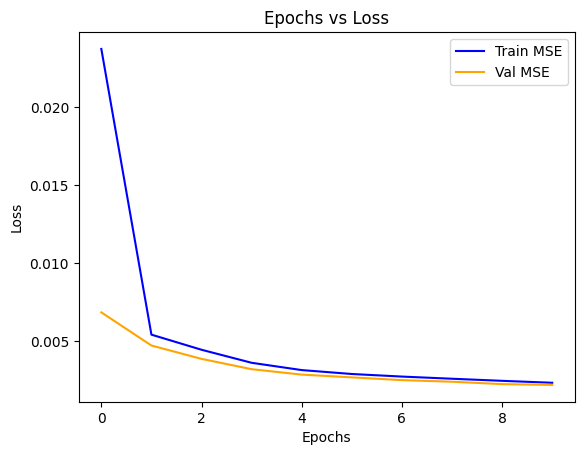

In [ ]:
visualise_loss(trainer_object_mse,'MSE')

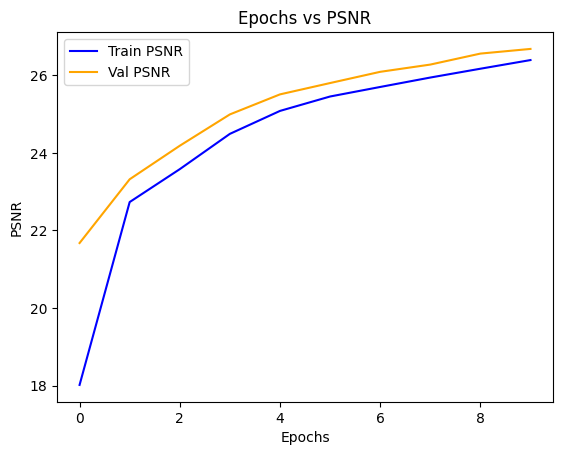

In [ ]:
visualise_psnr(trainer_object_mse)

## Test Metrics

In [ ]:
test_loss,test_psnr = test_loss_psnr(trainer_object_mse.model,test_dataset)
test_mssim = calculate_mssim(trainer_object_mse.model,test_dataset)

print(f"SRResNet_mse Test Loss: {test_loss}")
print(f"SRResNet_mse Test PSNR: {test_psnr}")
print(f"SRResNet_mse Test MSSIM: {test_mssim}")

SRResNet_mse Test Loss: 0.0021846092583765043
SRResNet_mse Test PSNR: 28.269584210541638
SRResNet_mse Test MSSIM: 0.7988783878063801


# SRResNet with Perceptual Loss

## Setting Up

In [7]:
args_perceptual = models.ModelArgs(loss = 'perceptual',
                        device = "cuda" if torch.cuda.is_available() else "cpu",
                        perceptual_loss_model = 'vgg16',
                        selected_layers = (3,8,15,29))
model_perceptual = models.SRResNet(args_perceptual)

In [8]:
# Model summary
torchinfo.summary(model_perceptual,input_size=(1,3,300,300))

Layer (type:depth-idx)                   Output Shape              Param #
SRResNet                                 [1, 3, 600, 600]          14,714,688
├─Sequential: 1-1                        [1, 3, 600, 600]          --
│    └─Conv2d: 2-1                       [1, 64, 300, 300]         4,864
│    └─Sequential: 2-2                   [1, 64, 300, 300]         --
│    │    └─ResidualBlock: 3-1           [1, 64, 300, 300]         4,192
│    │    └─ResidualBlock: 3-2           [1, 64, 300, 300]         4,192
│    │    └─ResidualBlock: 3-3           [1, 64, 300, 300]         4,192
│    │    └─ResidualBlock: 3-4           [1, 64, 300, 300]         4,192
│    └─Conv2d: 2-3                       [1, 32, 300, 300]         18,464
│    └─Sequential: 2-4                   [1, 32, 600, 600]         --
│    │    └─SubPixelConv: 3-5            [1, 32, 600, 600]         36,992
│    └─Conv2d: 2-5                       [1, 3, 600, 600]          867
│    └─Sigmoid: 2-6                      [1, 3, 600, 

In [8]:
configs_perceptual = trainer.TrainConfigs(epochs = 10,
                               save_every = 2,
                               batch_size = 32,
                               save_path = '/content/drive/MyDrive/Super_Resolution/SRResNet_Perceptual',
                               images_path = '/content/images',
                               train_csv_path = '/content/train.csv',
                               val_csv_path = '/content/val.csv')

trainer_object_perceptual = trainer.Trainer(configs_perceptual,
                                 model_perceptual,
                                 torch.optim.Adam)

## Training

In [9]:
trainer_object_perceptual.train()

185it [04:26,  1.44s/it, loss=2.87, psnr=13.1]


Val loss: 2.3764087524723783 | Val psnr: 12.708117674748856


185it [04:27,  1.45s/it, loss=1.79, psnr=14.6]


Val loss: 1.729201527990411 | Val psnr: 14.584174936937222


185it [04:28,  1.45s/it, loss=1.41, psnr=17.7]


Val loss: 1.3492332939688665 | Val psnr: 18.105757283583706


185it [04:29,  1.45s/it, loss=1.27, psnr=20.1]


Val loss: 1.1877125483081854 | Val psnr: 20.075708082144896


185it [04:29,  1.46s/it, loss=1.04, psnr=20.2]


Val loss: 1.1088412472617803 | Val psnr: 20.573713287126388


185it [04:28,  1.45s/it, loss=1.09, psnr=20.9]


Val loss: 1.0741639621202936 | Val psnr: 20.865372088668472


185it [04:25,  1.44s/it, loss=1.22, psnr=20.6]


Val loss: 1.0460074705264566 | Val psnr: 21.176917601341486


185it [04:28,  1.45s/it, loss=1.03, psnr=22]


Val loss: 1.006074720774355 | Val psnr: 21.624631672654004


185it [04:28,  1.45s/it, loss=0.801, psnr=22.1]


Val loss: 1.0084935742882817 | Val psnr: 22.054834936242628


185it [04:28,  1.45s/it, loss=1.05, psnr=22.2]


Val loss: 0.9914564354009977 | Val psnr: 22.5266774684715


In [10]:
trainer_object_perceptual.save()

## Loss Curves

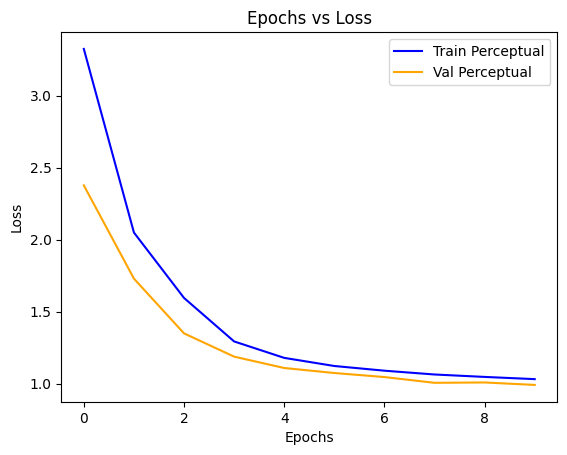

In [11]:
visualise_loss(trainer_object_perceptual,'Perceptual')

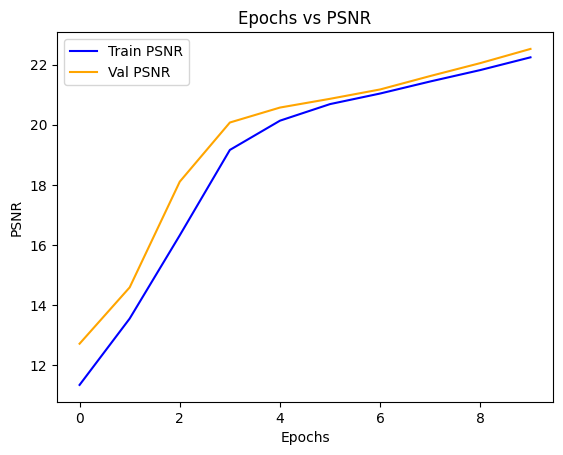

In [12]:
visualise_psnr(trainer_object_perceptual)

## Test Metrics

In [13]:
test_loss,test_psnr = test_loss_psnr(trainer_object_perceptual.model,test_dataset)
test_mssim = calculate_mssim(trainer_object_perceptual.model,test_dataset)

print(f"SRCNN_perceptual Test Loss: {test_loss}")
print(f"SRCNN_perceptual Test PSNR: {test_psnr}")
print(f"SRCNN_perceptual Test MSSIM: {test_mssim}")

SRCNN_perceptual Test Loss: 0.9726030938478543
SRCNN_perceptual Test PSNR: 22.753604386914244
SRCNN_perceptual Test MSSIM: 0.519923809114264


# SRResNet MSE with Weighted Perceptual Loss

## Setting Up

In [6]:
args_mse_percp = models.ModelArgs(loss = 'perceptual_mse',
                        device = "cuda" if torch.cuda.is_available() else "cpu",
                        perceptual_loss_model = 'vgg16',
                        perceptual_weight=0.001)
model_mse_percp = models.SRResNet(args_mse_percp)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 102MB/s] 


In [7]:
# Model summary
torchinfo.summary(model_mse_percp,input_size=(1,3,300,300))

Layer (type:depth-idx)                   Output Shape              Param #
SRResNet                                 [1, 3, 600, 600]          14,714,688
├─Sequential: 1-1                        [1, 3, 600, 600]          --
│    └─Conv2d: 2-1                       [1, 64, 300, 300]         4,864
│    └─Sequential: 2-2                   [1, 64, 300, 300]         --
│    │    └─ResidualBlock: 3-1           [1, 64, 300, 300]         4,192
│    │    └─ResidualBlock: 3-2           [1, 64, 300, 300]         4,192
│    │    └─ResidualBlock: 3-3           [1, 64, 300, 300]         4,192
│    │    └─ResidualBlock: 3-4           [1, 64, 300, 300]         4,192
│    └─Conv2d: 2-3                       [1, 32, 300, 300]         18,464
│    └─Sequential: 2-4                   [1, 32, 600, 600]         --
│    │    └─SubPixelConv: 3-5            [1, 32, 600, 600]         36,992
│    └─Conv2d: 2-5                       [1, 3, 600, 600]          867
│    └─Sigmoid: 2-6                      [1, 3, 600, 

In [8]:
configs_mse_percp = trainer.TrainConfigs(epochs = 10,
                               save_every = 2,
                               batch_size = 32,
                               save_path = '/content/drive/MyDrive/Super_Resolution/SRResNet_MSE_Perceptual',
                               images_path = '/content/images',
                               train_csv_path = '/content/train.csv',
                               val_csv_path = '/content/val.csv')

trainer_object_mse_percp = trainer.Trainer(configs_mse_percp,
                                 model_mse_percp,
                                 torch.optim.Adam)

## Training

In [9]:
trainer_object_mse_percp.train()

185it [04:25,  1.43s/it, loss=0.011, psnr=21.2]


Val loss: 0.010133466530838258 | Val psnr: 21.594925979800088


185it [04:28,  1.45s/it, loss=0.00665, psnr=24.3]


Val loss: 0.0071794920738317645 | Val psnr: 23.66805701972022


185it [04:32,  1.47s/it, loss=0.0057, psnr=24.7]


Val loss: 0.006047308363060748 | Val psnr: 24.64785387712822


185it [04:29,  1.46s/it, loss=0.00472, psnr=25.9]


Val loss: 0.005209868514837246 | Val psnr: 25.384476668134592


185it [04:26,  1.44s/it, loss=0.00524, psnr=25.4]


Val loss: 0.004731453498018873 | Val psnr: 25.852198134901077


185it [04:29,  1.46s/it, loss=0.00423, psnr=26.5]


Val loss: 0.004384928978399874 | Val psnr: 26.144730145940922


185it [04:29,  1.46s/it, loss=0.00433, psnr=26.1]


Val loss: 0.004051569978428024 | Val psnr: 26.510781774662828


185it [04:29,  1.46s/it, loss=0.00446, psnr=25.8]


Val loss: 0.003779276625753578 | Val psnr: 26.777212917240128


185it [04:27,  1.45s/it, loss=0.00353, psnr=26.9]


Val loss: 0.003486170677949595 | Val psnr: 27.173170071654777


185it [04:29,  1.46s/it, loss=0.0032, psnr=27.6]


Val loss: 0.0033586253097006124 | Val psnr: 27.284354748035476


In [10]:
trainer_object_mse_percp.save()

## Loss Curves

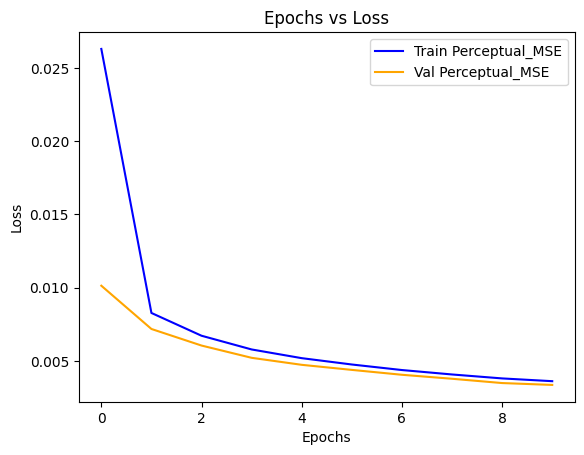

In [11]:
visualise_loss(trainer_object_mse_percp,'Perceptual_MSE')

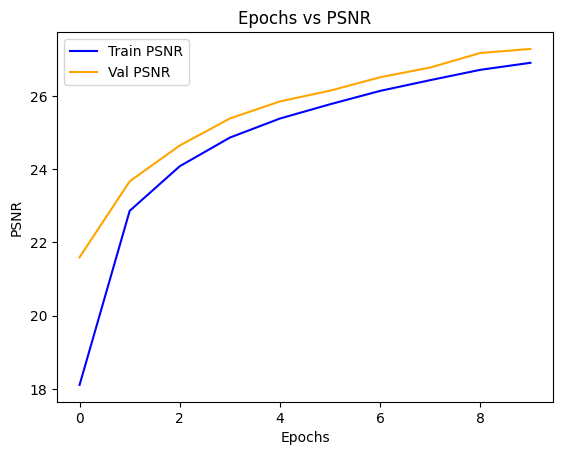

In [12]:
visualise_psnr(trainer_object_mse_percp)

## Test Metrics

In [13]:
test_loss,test_psnr = test_loss_psnr(trainer_object_mse_percp.model,test_dataset)
test_mssim = calculate_mssim(trainer_object_mse_percp.model,test_dataset)

print(f"SRCNN_mse_perceptual Test Loss: {test_loss}")
print(f"SRCNN_mse_perceptual Test PSNR: {test_psnr}")
print(f"SRCNN_mse_perceptual Test MSSIM: {test_mssim}")

SRCNN_mse_perceptual Test Loss: 0.0033346727149055687
SRCNN_mse_perceptual Test PSNR: 28.83809666511009
SRCNN_mse_perceptual Test MSSIM: 0.8169519386288278
